# Task 5: RPCA with Mixed Norms

Add your solution to this task from the manual in the cells below.

In [1]:
def prox_l12(S, lambda_val):
    row_norms = torch.norm(S, p=2, dim=1, keepdim=True)
    scale = torch.clamp(1 - lambda_val / row_norms, min=0)
    return S * scale

def prox_nuclear_norm(L, tau):
    batch_size, channels, height, width = L.shape
    L_flat = L.view(batch_size * channels, height, width)  # Flatten to apply SVD on each channel separately
    processed = []
    
    for i in range(L_flat.size(0)):
        U, S, V = torch.svd(L_flat[i])
        S_thresh = torch.clamp(S - tau, min=0)
        processed.append(U @ torch.diag(S_thresh) @ V.t())
    
    processed = torch.stack(processed)
    return processed.view(batch_size, channels, height, width)


# Functions for L(1,2) and L(2,1) norms

In [2]:
import numpy as np

def l12_norm(A):
    return np.sum(np.linalg.norm(A, axis=1))

def l21_norm(A):
    return np.sum(np.linalg.norm(A, axis=0))

A = np.array([[2, 2],
              [0, 0]])

l12 = l12_norm(A)
l21 = l21_norm(A)

print("Matrix A:")
print(A)
print("\n(1,2)-norm of A:", l12)
print("(2,1)-norm of A:", l21)

Matrix A:
[[2 2]
 [0 0]]

(1,2)-norm of A: 2.8284271247461903
(2,1)-norm of A: 4.0


Epoch [1/5], Loss: 343.5987
Epoch [2/5], Loss: 343.5989
Epoch [3/5], Loss: 343.5989
Epoch [4/5], Loss: 343.5986
Epoch [5/5], Loss: 343.5989
Training complete.


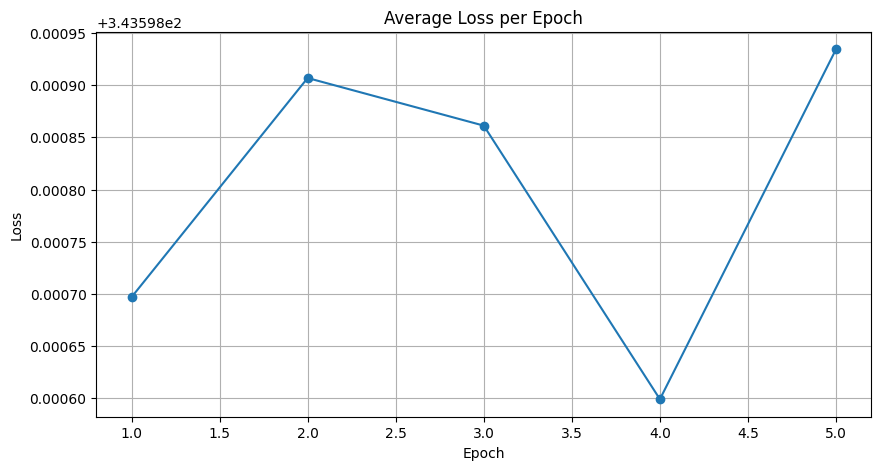

Reconstruction Error: 14.7870


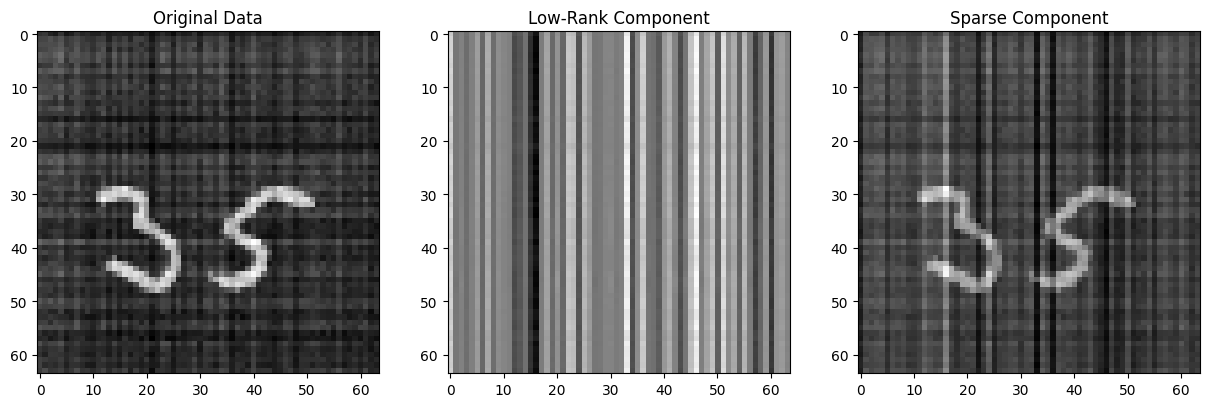

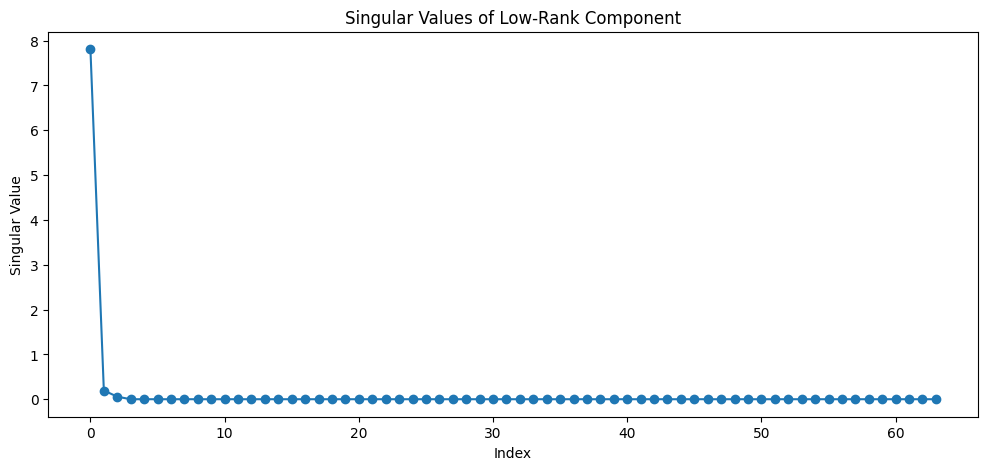

Sparsity (non-zero elements in S): 4096


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Define the device for computation (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the Moving MNIST Dataset
def load_mnist(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    L, S, X = data  # Unpack the tuple directly
    return torch.tensor(L, dtype=torch.float32), torch.tensor(S, dtype=torch.float32), torch.tensor(X, dtype=torch.float32)

class MovingMNISTDataset(Dataset):
    def __init__(self, L, S, X):
        self.L = L
        self.S = S
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# RPCA Model Definition
class RPCA_ALM(nn.Module):
    def __init__(self, lambda_1=0.01, lambda_2=0.01, mu=0.01, n_iters=10, tol=1e-4):
        super(RPCA_ALM, self).__init__()
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.mu = mu
        self.n_iters = n_iters
        self.tol = tol

    def prox_nuclear(self, L, tau):
        U, S, Vh = torch.linalg.svd(L, full_matrices=False)
        S = torch.clamp(S - tau, min=0)
        # Perform batch-wise multiplication
        return torch.bmm(U, torch.bmm(torch.diag_embed(S), Vh.transpose(-2, -1)))

    def prox_l1_l2(self, S, tau):
        norm = torch.norm(S, dim=2, keepdim=True)
        scaling = torch.clamp(1 - tau / (norm + 1e-8), min=0)
        return S * scaling

    def forward(self, X):
        L = X.clone()
        S = torch.zeros_like(X)
        Y = torch.zeros_like(X)

        for _ in range(self.n_iters):
            L_old, S_old = L, S

            # Proximal operators
            L = self.prox_nuclear(X - S + Y / self.mu, self.lambda_1 / self.mu)
            S = self.prox_l1_l2(X - L + Y / self.mu, self.lambda_2 / self.mu)

            # Update Y
            Y += self.mu * (X - L - S)

            # Convergence check
            if torch.norm(L - L_old) < self.tol and torch.norm(S - S_old) < self.tol:
                break

        return L, S

# Helper Function to Ensure Data is 3D
def ensure_3d(X):
    if X.dim() == 2:
        X = X.unsqueeze(0)  # Add batch dimension if missing
    return X

# Loss Function
def rpca_loss(X, L, S, lambda_1, lambda_2):
    frobenius_norm = torch.norm(X - L - S, p='fro')
    # Compute nuclear norm across batch
    nuclear_norm = lambda_1 * torch.sum(torch.linalg.norm(L, ord="nuc", dim=(-2, -1)))
    l1_norm = lambda_2 * torch.norm(S, p=1)
    return frobenius_norm + nuclear_norm + l1_norm

# Load and prepare the dataset
filename = "/kaggle/input/dataset/moving_mnist.pkl"
L, S, X = load_mnist(filename)
dataset = MovingMNISTDataset(L, S, X)

# Train-Test Split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
gen = torch.Generator().manual_seed(42)  # For reproducibility
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

# Data Loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Initialization
model = RPCA_ALM().to(device)

# Function to visualize components
def visualize_components(original, low_rank, sparse):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(original.cpu().numpy(), cmap='gray')
    ax[0].set_title("Original Data")
    
    ax[1].imshow(low_rank.cpu().numpy(), cmap='gray')
    ax[1].set_title("Low-Rank Component")
    
    ax[2].imshow(sparse.cpu().numpy(), cmap='gray')
    ax[2].set_title("Sparse Component")
    
    plt.show()

# Track losses for plotting
loss_values = []  # Store losses for plotting

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0.0
    for X_batch in train_loader:
        X_batch = X_batch.to(device)

        # Forward pass
        L, S = model(X_batch)
        loss = rpca_loss(X_batch, L, S, model.lambda_1, model.lambda_2)

        total_loss += loss.item()

    # Average Loss for the Epoch
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete.")

# Plotting Average Loss over Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
plt.title("Average Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Evaluation function with visualizations
def evaluate_rpca_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        for X_batch in data_loader:
            X_batch = X_batch.to(device)  # Ensure data is on the correct device
            X_batch = ensure_3d(X_batch)

            # Run the RPCA model to get low-rank (L) and sparse (S) components
            L, S = model(X_batch)

            # Calculate reconstruction error for the batch
            reconstruction_error = torch.norm(L + S - X_batch, p='fro').item()
            print(f"Reconstruction Error: {reconstruction_error:.4f}")

            # Visualize the original, low-rank, and sparse components for the first sample
            visualize_components(X_batch[0], L[0], S[0])

            # Analyze the singular values of the low-rank component
            U, Sigma, V = torch.linalg.svd(L[0], full_matrices=False)
            plt.figure(figsize=(12, 5))
            plt.plot(Sigma.cpu().numpy(), marker='o')
            plt.title("Singular Values of Low-Rank Component")
            plt.xlabel("Index")
            plt.ylabel("Singular Value")
            plt.show()

            # Calculate and print sparsity of the first sample
            sparsity = torch.sum(S[0] != 0).item()
            print(f"Sparsity (non-zero elements in S): {sparsity}")

            break  # Stop after the first batch for a quick evaluation

# Evaluate the model on test data
evaluate_rpca_model(model, test_loader)